In [6]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

Загрузим данные датасета MNIST

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [8]:
data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Разделение на тренировочную и валидационную выборку
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Создание загрузчиков данных
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

num_classes = 10
device = 'cpu'

В этом датасете следующий формат данных:
В каждом тензоре есть матрица со значениями от 0 до 1 (степенью закрашенности пикселя) размером 28x28 и лейблом самой картинки

Выведу первые 10 изображений

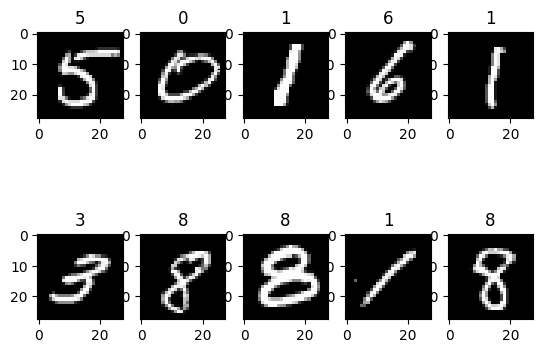

In [9]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = train_data[i][0].reshape(28, 28)
    label = train_data[i][1]
    plt.imshow(img.reshape(28, 28), cmap = plt.get_cmap('gray'))
    plt.title(label)

In [15]:
# Подготовка данных для sklearn
X_train = np.array([data[0].numpy().flatten() for data in train_data])
y_train = np.array([data[1] for data in train_data])
X_val = np.array([data[0].numpy().flatten() for data in val_data])
y_val = np.array([data[1] for data in val_data])

Проверю классовую переменную на сбалансированность данных

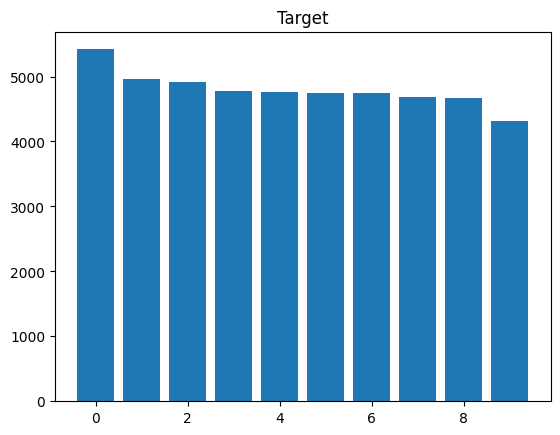

In [16]:
y = pd.DataFrame(y_train).value_counts()
x = np.linspace(0, 9, 10)

plt.title('Target')
plt.bar(x, y);

Дизбаланса классов нет

Создаем словарь для записи скора каждой модели

In [17]:
models_scores = dict()

Логистическая регрессия

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [19]:
y_pred = logreg.predict(X_val)
y_pred_proba = logreg.predict_proba(X_val)

f1_macro = f1_score(y_val, y_pred, average='macro')
roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovo')

print(f'F1 Score (Logistic Regression): {f1_macro:.4f}')
print(f'roc_auc_score (Logistic Regression): {roc_auc:.4f}')

F1 Score (Logistic Regression): 0.9202
roc_auc_score (Logistic Regression): 0.9929


In [20]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1175
           1       0.95      0.97      0.96      1322
           2       0.90      0.89      0.89      1174
           3       0.91      0.90      0.90      1219
           4       0.93      0.94      0.93      1176
           5       0.89      0.88      0.89      1104
           6       0.95      0.95      0.95      1177
           7       0.93      0.92      0.93      1299
           8       0.89      0.87      0.88      1160
           9       0.90      0.91      0.90      1194

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



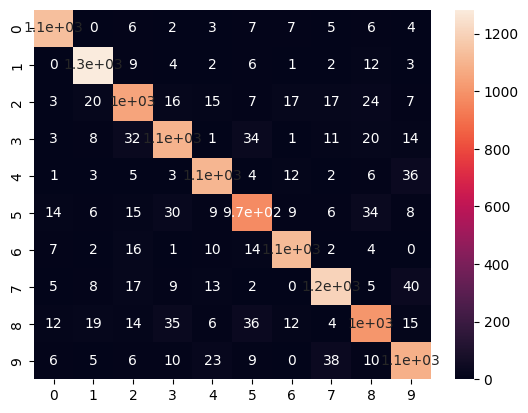

In [21]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True);

In [22]:
models_scores['LogReg'] = [f1_macro, roc_auc]

k-ближайших соседей

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [24]:
y_pred = knn.predict(X_val)
y_pred_proba = knn.predict_proba(X_val)

f1_macro = f1_score(y_val, y_pred, average='macro')
roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovo')

print(f'F1 Score (k-NN): {f1_macro:.4f}')
print(f'roc_auc_score (k-NN): {roc_auc:.4f}')

F1 Score (k-NN): 0.9714
roc_auc_score (k-NN): 0.9953


In [25]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1175
           1       0.95      1.00      0.97      1322
           2       0.98      0.96      0.97      1174
           3       0.96      0.97      0.97      1219
           4       0.98      0.97      0.97      1176
           5       0.96      0.97      0.97      1104
           6       0.98      0.99      0.99      1177
           7       0.97      0.97      0.97      1299
           8       0.99      0.93      0.96      1160
           9       0.96      0.96      0.96      1194

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



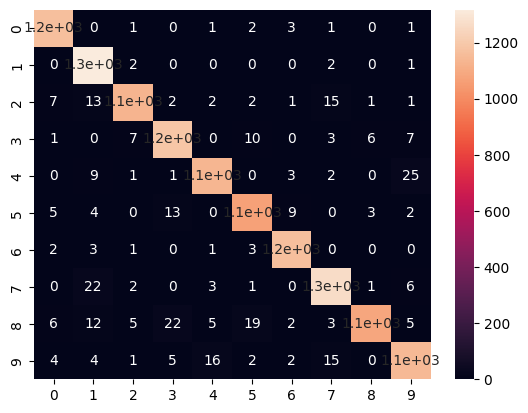

In [26]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True);

In [27]:
models_scores['K-nn Classifier'] = [f1_macro, roc_auc]

Метод опорных векторов

In [28]:
from sklearn.svm import SVC

svc = SVC(probability=True)
svc.fit(X_train, y_train)

SVC(probability=True)

In [29]:
y_pred = svc.predict(X_val)
y_pred_proba = svc.predict_proba(X_val)

f1_macro = f1_score(y_val, y_pred, average='macro')
roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovo')

print(f'F1 Score (SVM): {f1_macro:.4f}')
print(f'roc_auc_score (SVM): {roc_auc:.4f}')

F1 Score (SVM): 0.9774
roc_auc_score (SVM): 0.9996


In [30]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1175
           1       0.99      0.99      0.99      1322
           2       0.96      0.98      0.97      1174
           3       0.98      0.96      0.97      1219
           4       0.97      0.98      0.98      1176
           5       0.98      0.97      0.97      1104
           6       0.99      0.99      0.99      1177
           7       0.98      0.97      0.98      1299
           8       0.97      0.97      0.97      1160
           9       0.97      0.97      0.97      1194

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



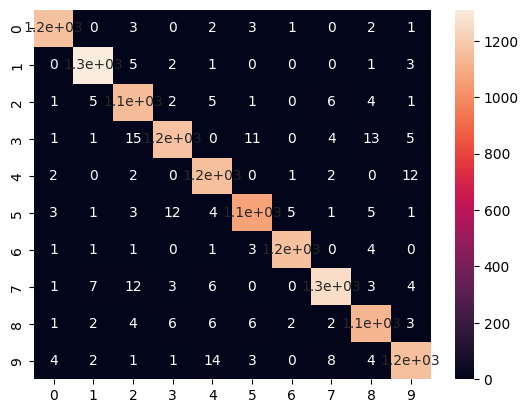

In [31]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True);

In [32]:
models_scores['SVM'] = [f1_macro, roc_auc]

Дерево решений

In [33]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [34]:
y_pred = tree.predict(X_val)
y_pred_proba = tree.predict_proba(X_val)

f1_macro = f1_score(y_val, y_pred, average='macro')
roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovo')

print(f'F1 Score (Decision Tree): {f1_macro:.4f}')
print(f'roc_auc_score (Decision Tree): {roc_auc:.4f}')

F1 Score (Decision Tree): 0.8653
roc_auc_score (Decision Tree): 0.9251


In [35]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1175
           1       0.92      0.96      0.94      1322
           2       0.85      0.85      0.85      1174
           3       0.84      0.84      0.84      1219
           4       0.86      0.86      0.86      1176
           5       0.83      0.81      0.82      1104
           6       0.89      0.89      0.89      1177
           7       0.90      0.91      0.91      1299
           8       0.81      0.79      0.80      1160
           9       0.82      0.83      0.83      1194

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000



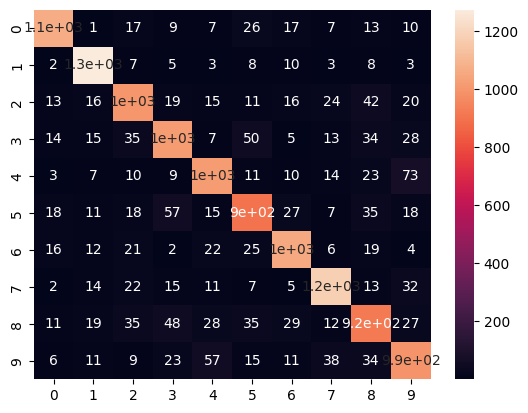

In [36]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True);

In [37]:
models_scores['DT Classifier'] = [f1_macro, roc_auc]

Случайный лес

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
y_pred = forest.predict(X_val)
y_pred_proba = forest.predict_proba(X_val)

f1_macro = f1_score(y_val, y_pred, average='macro')
roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovo')

print(f'F1 Score (Random Forest): {f1_macro:.4f}')
print(f'roc_auc_score (Random Forest): {roc_auc:.4f}')

F1 Score (Random Forest): 0.9678
roc_auc_score (Random Forest): 0.9988


In [40]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1175
           1       0.99      0.99      0.99      1322
           2       0.95      0.97      0.96      1174
           3       0.97      0.95      0.96      1219
           4       0.96      0.97      0.97      1176
           5       0.96      0.96      0.96      1104
           6       0.98      0.98      0.98      1177
           7       0.97      0.96      0.97      1299
           8       0.96      0.96      0.96      1160
           9       0.96      0.95      0.95      1194

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



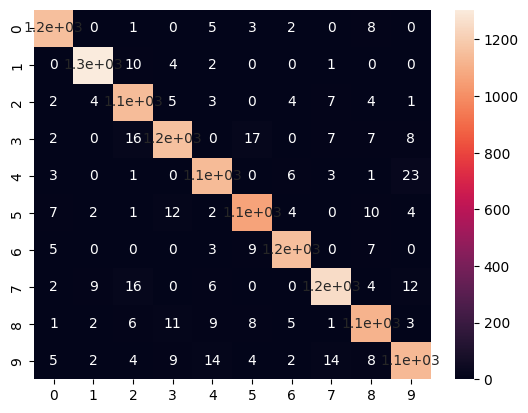

In [41]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True);

In [42]:
models_scores['RF Classifier'] = [f1_macro, roc_auc]

Построение бейзлайн сверточной нейронной сети

In [43]:
class CNNModel(nn.Module):
    def __init__(self, output_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Обучение и оценка бейзлайн модели

Epoch 1/10, Train Loss: 0.1804, Val Loss: 0.0614, F1 Score: 0.9816, ROC AUC: 0.9997
Epoch 2/10, Train Loss: 0.0509, Val Loss: 0.0461, F1 Score: 0.9864, ROC AUC: 0.9998
Epoch 3/10, Train Loss: 0.0353, Val Loss: 0.0479, F1 Score: 0.9861, ROC AUC: 0.9998
Epoch 4/10, Train Loss: 0.0237, Val Loss: 0.0360, F1 Score: 0.9893, ROC AUC: 0.9999
Epoch 5/10, Train Loss: 0.0180, Val Loss: 0.0397, F1 Score: 0.9891, ROC AUC: 0.9999
Epoch 6/10, Train Loss: 0.0135, Val Loss: 0.0478, F1 Score: 0.9880, ROC AUC: 0.9999
Epoch 7/10, Train Loss: 0.0126, Val Loss: 0.0399, F1 Score: 0.9889, ROC AUC: 0.9999
Epoch 8/10, Train Loss: 0.0099, Val Loss: 0.0410, F1 Score: 0.9906, ROC AUC: 0.9999
Epoch 9/10, Train Loss: 0.0090, Val Loss: 0.0428, F1 Score: 0.9904, ROC AUC: 0.9998
Epoch 10/10, Train Loss: 0.0052, Val Loss: 0.0460, F1 Score: 0.9906, ROC AUC: 0.9999


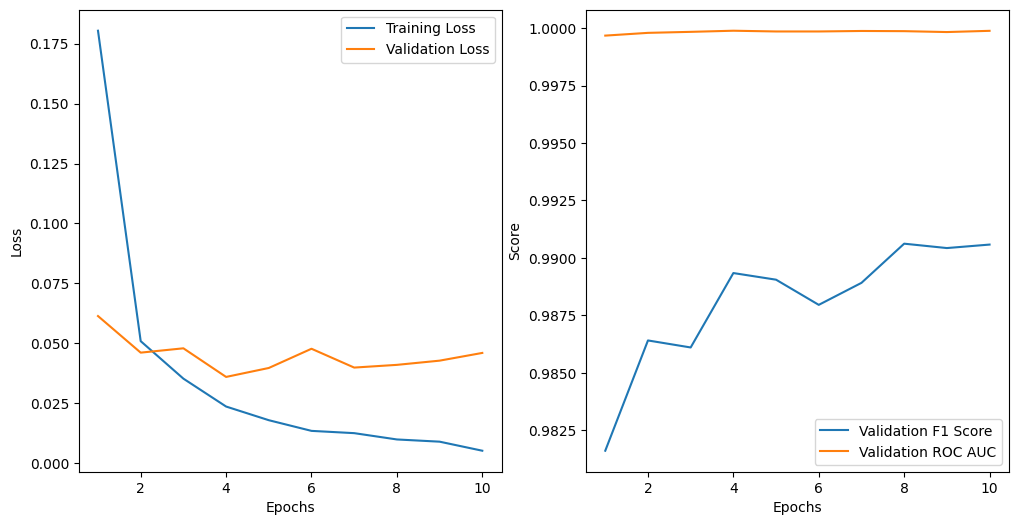

In [44]:
cnn_model = CNNModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(nn.functional.softmax(outputs, dim=1).cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='macro')
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovo')
    return f1, roc_auc, running_loss / len(val_loader)

num_epochs = 10
train_losses = []
val_losses = []
val_f1_scores = []
val_roc_auc_scores = []

for epoch in range(num_epochs):
    train_loss = train_model(cnn_model, train_loader, criterion, optimizer, device)
    val_f1, val_roc_auc, val_loss = evaluate_model(cnn_model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    val_roc_auc_scores.append(val_roc_auc)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1 Score: {val_f1:.4f}, ROC AUC: {val_roc_auc:.4f}')

# Графики обучения и потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Validation F1 Score')
plt.plot(range(1, num_epochs + 1), val_roc_auc_scores, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.show()

In [45]:
models_scores['CNN baseline'] = max(val_f1_scores), max(val_roc_auc_scores)

Оптимизация гиперпараметров

Для этого был использован gridsearch, так как он позволяет исследовать все комбинации гиперпараметров и найти оптимальные настройки, которые обеспечат наилучшую производительность модели.
gridsearch может быть ресурсоемким, однако будут рассмотрены все возможные комбинации параметров.

In [46]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'lr': [0.0001],
    'batch_size': [32],
    'conv1_out_channels': [32],
    'conv2_out_channels': [128],
    'fc1_units': [128]
}

param_list = list(ParameterGrid(param_grid))
best_f1 = 0
best_params = None
best_model = None

for params in param_list:
    # Определение модели с новыми гиперпараметрами
    class CNNModelOptimized(nn.Module):
        def __init__(self, params, output_size):
            super(CNNModelOptimized, self).__init__()
            self.conv1 = nn.Conv2d(1, params['conv1_out_channels'], kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(params['conv1_out_channels'], params['conv2_out_channels'], kernel_size=3, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.fc1 = nn.Linear(params['conv2_out_channels'] * 7 * 7, params['fc1_units'])
            self.fc2 = nn.Linear(params['fc1_units'], output_size)

        def forward(self, x):
            x = self.pool(nn.functional.relu(self.conv1(x)))
            x = self.pool(nn.functional.relu(self.conv2(x)))
            x = x.view(-1, params['conv2_out_channels'] * 7 * 7)
            x = nn.functional.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    model = CNNModelOptimized(params, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    
    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
    
    val_f1, val_roc_auc, val_loss = evaluate_model(model, val_loader, device)
    print(f'Params: {params}, F1 Score: {val_f1:.4f}, ROC AUC: {val_roc_auc:.4f}')
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_params = params 
        best_model = model

print(f'Best Params: {best_params}, Best F1 Score: {best_f1:.4f}')


Params: {'batch_size': 32, 'conv1_out_channels': 32, 'conv2_out_channels': 128, 'fc1_units': 128, 'lr': 0.0001}, F1 Score: 0.9887, ROC AUC: 0.9998
Best Params: {'batch_size': 32, 'conv1_out_channels': 32, 'conv2_out_channels': 128, 'fc1_units': 128, 'lr': 0.0001}, Best F1 Score: 0.9887


Обучение и оценка лучшей модели с метриками ROC AUC и F1 Score

Epoch 1/10, Train Loss: 0.0149, Val Loss: 0.0428, F1 Score: 0.9879, ROC AUC: 0.9998
Epoch 2/10, Train Loss: 0.0126, Val Loss: 0.0371, F1 Score: 0.9901, ROC AUC: 0.9999
Epoch 3/10, Train Loss: 0.0110, Val Loss: 0.0373, F1 Score: 0.9909, ROC AUC: 0.9999
Epoch 4/10, Train Loss: 0.0093, Val Loss: 0.0493, F1 Score: 0.9884, ROC AUC: 0.9998
Epoch 5/10, Train Loss: 0.0079, Val Loss: 0.0401, F1 Score: 0.9898, ROC AUC: 0.9998
Epoch 6/10, Train Loss: 0.0068, Val Loss: 0.0421, F1 Score: 0.9895, ROC AUC: 0.9999
Epoch 7/10, Train Loss: 0.0051, Val Loss: 0.0509, F1 Score: 0.9878, ROC AUC: 0.9998
Epoch 8/10, Train Loss: 0.0052, Val Loss: 0.0429, F1 Score: 0.9898, ROC AUC: 0.9999
Epoch 9/10, Train Loss: 0.0040, Val Loss: 0.0419, F1 Score: 0.9905, ROC AUC: 0.9999
Epoch 10/10, Train Loss: 0.0047, Val Loss: 0.0474, F1 Score: 0.9891, ROC AUC: 0.9998


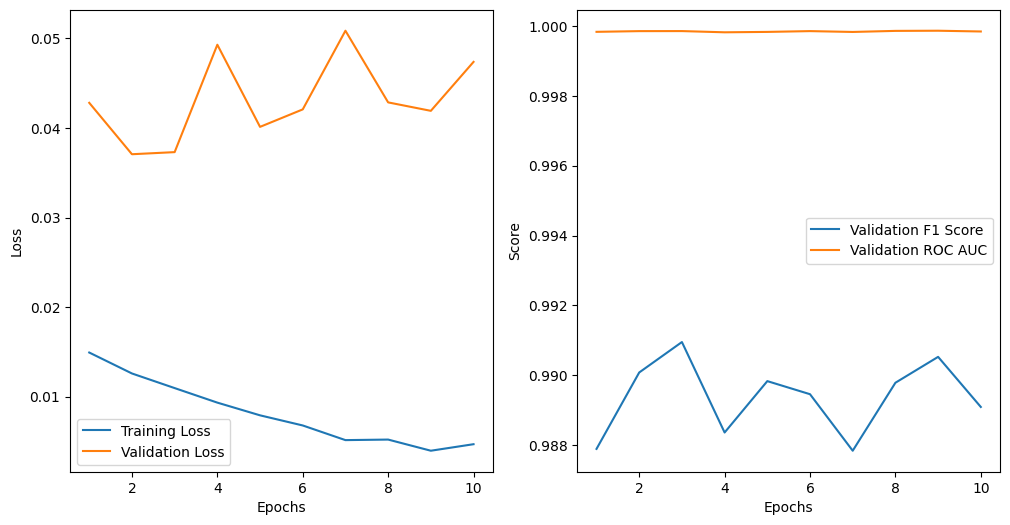

In [47]:
best_model.eval()
train_losses = []
val_losses = []
val_f1_scores = []
val_roc_auc_scores = []

for epoch in range(num_epochs):
    train_loss = train_model(best_model, train_loader, criterion, optimizer, device)
    val_f1, val_roc_auc, val_loss = evaluate_model(best_model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    val_roc_auc_scores.append(val_roc_auc)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1 Score: {val_f1:.4f}, ROC AUC: {val_roc_auc:.4f}')

# Графики обучения и потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Validation F1 Score')
plt.plot(range(1, num_epochs + 1), val_roc_auc_scores, label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.show()


In [48]:
models_scores['CNN GridSearch'] = max(val_f1_scores), max(val_roc_auc_scores)

In [49]:
pin = pd.DataFrame(models_scores, index=['f1_score_macro', 'roc_auc_score'])
pin

,LogReg,K-nn Classifier,SVM,DT Classifier,RF Classifier,CNN baseline,CNN GridSearch
f1_score_macro,0.920209,0.971412,0.977444,0.865276,0.967849,0.990618,0.990949
roc_auc_score,0.992901,0.995252,0.999569,0.925121,0.998829,0.999889,0.999867
